# KNHNES BASELINE AUTOML

### 변수 설명
- ID                 : 환자 ID
- N_Days             : 등록 시작 시점부터 censored 까지 기간
- Status             : 
- Drug               : 약물 처리군 / 플라시보 군
- Age                : 연령
- Sex                : 성별
- Ascites            : Y/N 배에 복수가 찼는지
- Hepatomegaly       : Y/N 간 비대칭이 생겼는지
- Spiders            : Y/N 거미혈관증 유무 주로 여성에게 많이 발생할 수 있음 ( 에스트로겐과 관련 )
- Edema              : Y/N 부종 유무
- Bilirubin          : 적혈구 파괴 수치 (파괴 수치가 높을수록 간염이 존재할 확률이 높음)
- Cholesterol        : 콜레스테롤 상승시 지방간이 생김 ( 높을수록 간에 안좋음 )
- Albumin            : 단백질의 한 종류 (값이 하락할 수록 간 기능이 안좋음)
- Copper             : 신체의 필수 미네랄 하나 (단백질, 효소) 수치가 높을 수록 대사 장애 발생 가능성 높음
- Alk_Phos           : (alp) 수치가 높으면 간의 문제가 있을 가능성 높음
- SGOT               : (AST) 간기능 검사의 주요 요소 [0, 40]이 정상 범위
- Tryglicerides      : 중성지방 150 미만이 정상.
- Platelets          : 혈소판 수치가 떨어질 수록 간 경변이 발생 가능
- Prothrombin        : 혈액이 얼마나 빨리 굳는지 측정 시간 ( 시간이 증가하면 응고 시간이 늘어나기 때문에 간경변 의심할 수 있음, 높을수록 의심)
- Stage              : 간경변의 4단계 1부터 4까지의 순서

## 1. Setting

In [1]:
# import modules
import pandas as pd
import numpy as np
import warnings

# graph
from matplotlib import pyplot as plt
import seaborn as sns

# split
from sklearn.model_selection import train_test_split

# modeling
from supervised.automl import AutoML

# XAI
import shap

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# 한글 깨짐 방지 및 warnings 알림 금지
plt.rc('font', family='NanumSquare')
warnings.filterwarnings(action = 'ignore')

In [165]:
# load data
data = pd.read_csv('../Data/K_ALL_sero.csv')

## 2. Info

In [166]:
# shape
data.shape

(120181, 44)

In [167]:
# type
data.dtypes

id              object
ID_fam          object
year             int64
region           int64
sex              int64
age              int64
age_month      float64
DC2_dg         float64
DC2_ag         float64
DC2_pr         float64
DC2_pt         float64
DK8_dg         float64
DK8_ag         float64
DK8_pr         float64
DK8_pt         float64
DK9_dg         float64
DK9_ag         float64
DK9_pr         float64
DK9_pt         float64
DK4_dg         float64
DK4_ag         float64
DK4_pr         float64
DK4_pt         float64
HE_glu         float64
HE_HbA1c       float64
HE_insulin     float64
HE_chol        float64
HE_HDL_st2     float64
HE_TG          float64
HE_LDL_drct    float64
HE_ast         float64
HE_alt         float64
HE_hepaB       float64
HE_hepaC       float64
HE_HB          float64
HE_BUN         float64
HE_crea        float64
HE_WBC         float64
HE_RBC         float64
HE_Bplt        float64
HE_Uacid       float64
HE_Ubil        float64
HE_UCREA       float64
HE_Ualb    

In [168]:
data.describe()

,year,region,sex,age,age_month,DC2_dg,DC2_ag,DC2_pr,DC2_pt,DK8_dg,...,HE_HB,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_Uacid,HE_Ubil,HE_UCREA,HE_Ualb
count,120181.000000,120181.000000,120181.000000,120181.000000,7380.000000,109209.000000,109209.000000,109209.000000,109209.000000,109209.000000,...,95066.000000,95429.000000,95418.000000,95066.000000,95066.000000,90809.000000,38812.000000,93679.000000,59808.000000,42336.000000
mean,2013.879815,7.336068,1.544337,41.790100,47.915989,4.372304,890.520360,8.022892,8.022956,4.341584,...,13.958473,14.392281,0.817439,6.198065,4.596744,258.863318,5.134036,0.105445,152.005386,24.255969
std,4.233372,4.824593,0.498032,22.804382,20.720482,4.015360,31.828416,0.282229,0.282337,4.009308,...,1.560951,4.604838,0.257010,1.738748,0.478239,62.119848,1.384592,0.448463,85.442436,124.752252
min,2007.000000,1.000000,1.000000,1.000000,12.000000,0.000000,38.000000,0.000000,0.000000,0.000000,...,3.900000,2.000000,0.200000,1.300000,1.610000,9.000000,0.900000,0.000000,4.000000,0.090000
25%,2010.000000,3.000000,1.000000,23.000000,30.000000,0.000000,888.000000,8.000000,8.000000,0.000000,...,12.900000,11.000000,0.680000,5.000000,4.260000,218.000000,4.100000,0.000000,88.000000,3.500000
50%,2014.000000,8.000000,2.000000,43.000000,48.000000,8.000000,888.000000,8.000000,8.000000,8.000000,...,13.900000,14.000000,0.800000,5.960000,4.570000,255.000000,5.000000,0.000000,137.100000,7.100000
75%,2018.000000,11.000000,2.000000,61.000000,66.000000,8.000000,888.000000,8.000000,8.000000,8.000000,...,15.100000,17.000000,0.930000,7.100000,4.920000,295.000000,6.000000,0.000000,200.000000,13.900000
max,2021.000000,17.000000,2.000000,80.000000,83.000000,9.000000,999.000000,9.000000,9.000000,9.000000,...,21.300000,140.000000,17.530000,48.200000,9.640000,1880.000000,13.600000,4.000000,846.000000,5530.000000


In [169]:
data.isna().sum()

id              46828
ID_fam              0
year                0
region              0
sex                 0
age                 0
age_month      112801
DC2_dg          10972
DC2_ag          10972
DC2_pr          10972
DC2_pt          10972
DK8_dg          10972
DK8_ag          10972
DK8_pr          10972
DK8_pt          10972
DK9_dg          10972
DK9_ag          10972
DK9_pr          10972
DK9_pt          10972
DK4_dg          10972
DK4_ag          10972
DK4_pr          10972
DK4_pt          10972
HE_glu          24857
HE_HbA1c        48985
HE_insulin      68944
HE_chol         24809
HE_HDL_st2      24821
HE_TG           24809
HE_LDL_drct     99794
HE_ast          24753
HE_alt          24761
HE_hepaB        24757
HE_hepaC        57729
HE_HB           25115
HE_BUN          24752
HE_crea         24763
HE_WBC          25115
HE_RBC          25115
HE_Bplt         29372
HE_Uacid        81369
HE_Ubil         26502
HE_UCREA        60373
HE_Ualb         77845
dtype: int64

In [170]:
data.columns

Index(['id', 'ID_fam', 'year', 'region', 'sex', 'age', 'age_month', 'DC2_dg',
       'DC2_ag', 'DC2_pr', 'DC2_pt', 'DK8_dg', 'DK8_ag', 'DK8_pr', 'DK8_pt',
       'DK9_dg', 'DK9_ag', 'DK9_pr', 'DK9_pt', 'DK4_dg', 'DK4_ag', 'DK4_pr',
       'DK4_pt', 'HE_glu', 'HE_HbA1c', 'HE_insulin', 'HE_chol', 'HE_HDL_st2',
       'HE_TG', 'HE_LDL_drct', 'HE_ast', 'HE_alt', 'HE_hepaB', 'HE_hepaC',
       'HE_HB', 'HE_BUN', 'HE_crea', 'HE_WBC', 'HE_RBC', 'HE_Bplt', 'HE_Uacid',
       'HE_Ubil', 'HE_UCREA', 'HE_Ualb'],
      dtype='object')

## 3. use_data

In [171]:
# 사용할 데이터 만들기
use_data_B = data.drop(['id', 'ID_fam', 'age_month', 'year',
                      'DC2_dg', 'DC2_ag', 'DC2_pr',
                      'DC2_pt', 'DK8_dg', 'DK8_ag',
                      'DK8_pt', 'DK9_dg','DK4_pt', 'region',
                      'DK9_ag', 'DK9_pr', 'DK9_pt', 'HE_LDL_drct',
                      'DK4_dg', 'DK4_ag', 'DK4_pr','HE_hepaB', 'HE_hepaC'
                      ],
                      axis = 1)

use_data_C = data.drop(['id', 'ID_fam', 'age_month', 'year',
                      'DC2_dg', 'DC2_ag', 'DC2_pr',
                      'DC2_pt', 'DK8_dg', 'DK8_ag',
                      'DK8_pr', 'DK8_pt', 'DK9_dg', 'region',
                      'DK9_ag', 'DK4_pt', 'DK9_pt', 'HE_LDL_drct',
                      'DK4_dg', 'DK4_ag', 'DK4_pr', 'HE_hepaB', 'HE_hepaC'
                      ],
                      axis = 1)

In [172]:
use_data_B['DK8_pr'].value_counts()

DK8_pr
8.0    104685
9.0      3266
0.0       756
1.0       502
Name: count, dtype: int64

In [173]:
# hepaB,C have 0, 1
B = use_data_B[use_data_B['DK8_pr'].isin([0, 1])]
C = use_data_C[use_data_C['DK9_pr'].isin([0, 1])]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'sex'),
  Text(1, 0, 'age'),
  Text(2, 0, 'DK8_pr'),
  Text(3, 0, 'HE_glu'),
  Text(4, 0, 'HE_HbA1c'),
  Text(5, 0, 'HE_insulin'),
  Text(6, 0, 'HE_chol'),
  Text(7, 0, 'HE_HDL_st2'),
  Text(8, 0, 'HE_TG'),
  Text(9, 0, 'HE_ast'),
  Text(10, 0, 'HE_alt'),
  Text(11, 0, 'HE_HB'),
  Text(12, 0, 'HE_BUN'),
  Text(13, 0, 'HE_crea'),
  Text(14, 0, 'HE_WBC'),
  Text(15, 0, 'HE_RBC'),
  Text(16, 0, 'HE_Bplt'),
  Text(17, 0, 'HE_Uacid'),
  Text(18, 0, 'HE_Ubil'),
  Text(19, 0, 'HE_UCREA'),
  Text(20, 0, 'HE_Ualb')])

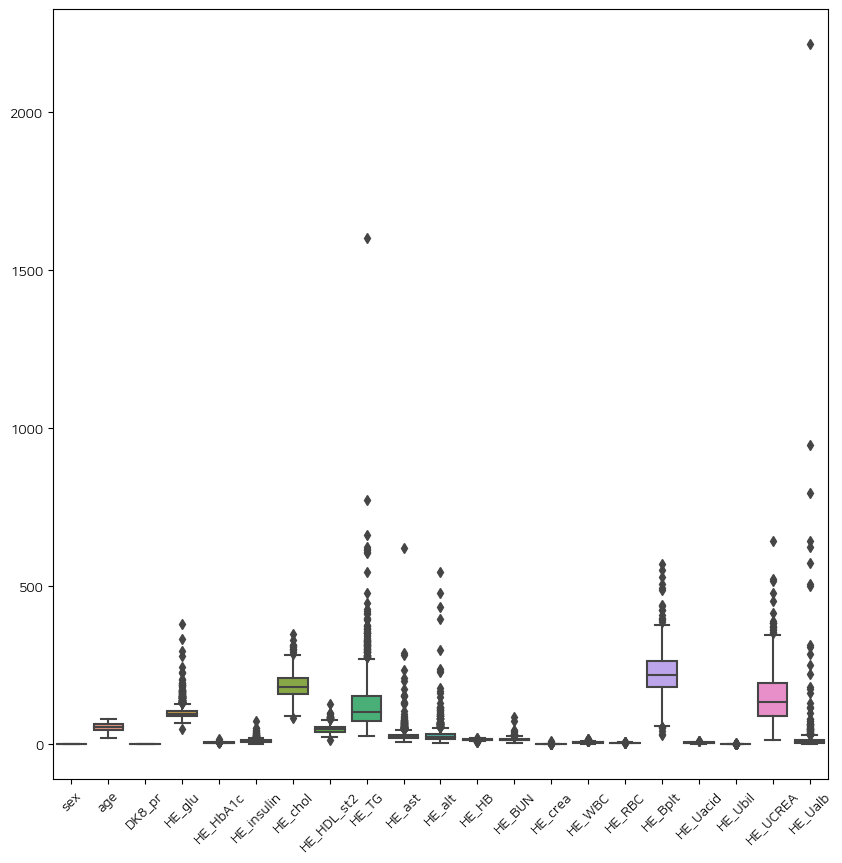

In [174]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=B)
plt.xticks(rotation = 45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'sex'),
  Text(1, 0, 'age'),
  Text(2, 0, 'DK9_pr'),
  Text(3, 0, 'HE_glu'),
  Text(4, 0, 'HE_HbA1c'),
  Text(5, 0, 'HE_insulin'),
  Text(6, 0, 'HE_chol'),
  Text(7, 0, 'HE_HDL_st2'),
  Text(8, 0, 'HE_TG'),
  Text(9, 0, 'HE_ast'),
  Text(10, 0, 'HE_alt'),
  Text(11, 0, 'HE_HB'),
  Text(12, 0, 'HE_BUN'),
  Text(13, 0, 'HE_crea'),
  Text(14, 0, 'HE_WBC'),
  Text(15, 0, 'HE_RBC'),
  Text(16, 0, 'HE_Bplt'),
  Text(17, 0, 'HE_Uacid'),
  Text(18, 0, 'HE_Ubil'),
  Text(19, 0, 'HE_UCREA'),
  Text(20, 0, 'HE_Ualb')])

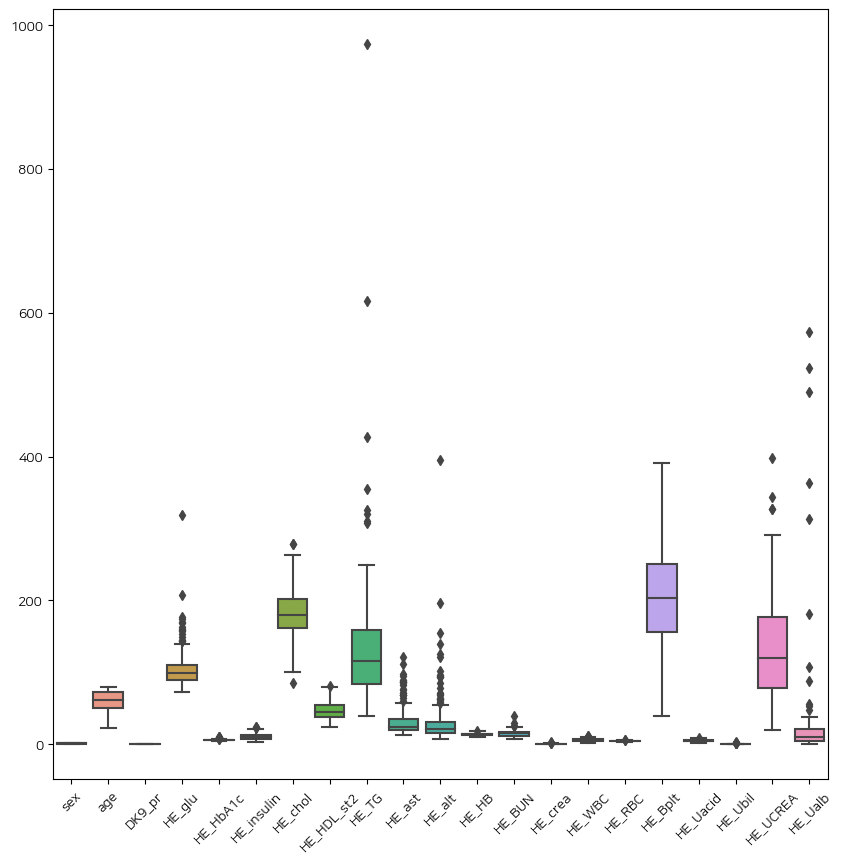

In [175]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=C)
plt.xticks(rotation = 45)

In [176]:
len(B)

1258

In [177]:
B.isna().sum()/len(B)*100

sex            0.000000
age            0.000000
DK8_pr         0.000000
HE_glu         4.292528
HE_HbA1c      33.227345
HE_insulin    45.151033
HE_chol        4.372019
HE_HDL_st2     4.372019
HE_TG          4.372019
HE_ast         4.292528
HE_alt         4.292528
HE_HB          4.372019
HE_BUN         4.292528
HE_crea        4.292528
HE_WBC         4.372019
HE_RBC         4.372019
HE_Bplt       12.559618
HE_Uacid      66.454690
HE_Ubil        4.372019
HE_UCREA      41.812401
HE_Ualb       60.731320
dtype: float64

In [178]:
C.isna().sum()/len(C)*100

sex            0.000000
age            0.000000
DK9_pr         0.000000
HE_glu        11.111111
HE_HbA1c      28.571429
HE_insulin    57.142857
HE_chol       11.111111
HE_HDL_st2    11.111111
HE_TG         11.111111
HE_ast        11.111111
HE_alt        11.111111
HE_HB         11.111111
HE_BUN        11.111111
HE_crea       11.111111
HE_WBC        11.111111
HE_RBC        11.111111
HE_Bplt       18.518519
HE_Uacid      62.962963
HE_Ubil        6.878307
HE_UCREA      42.328042
HE_Ualb       53.968254
dtype: float64

In [179]:
B[B['DK8_pr'] == 1].isna().sum()/len(B)*100

sex            0.000000
age            0.000000
DK8_pr         0.000000
HE_glu         1.589825
HE_HbA1c      12.718601
HE_insulin    18.044515
HE_chol        1.589825
HE_HDL_st2     1.589825
HE_TG          1.589825
HE_ast         1.589825
HE_alt         1.589825
HE_HB          1.589825
HE_BUN         1.589825
HE_crea        1.589825
HE_WBC         1.589825
HE_RBC         1.589825
HE_Bplt        5.802862
HE_Uacid      25.119237
HE_Ubil        1.828299
HE_UCREA      17.806041
HE_Ualb       25.198728
dtype: float64

In [180]:
B[B['DK8_pr'] == 0].isna().sum()/len(B)*100

sex            0.000000
age            0.000000
DK8_pr         0.000000
HE_glu         2.702703
HE_HbA1c      20.508744
HE_insulin    27.106518
HE_chol        2.782194
HE_HDL_st2     2.782194
HE_TG          2.782194
HE_ast         2.702703
HE_alt         2.702703
HE_HB          2.782194
HE_BUN         2.702703
HE_crea        2.702703
HE_WBC         2.782194
HE_RBC         2.782194
HE_Bplt        6.756757
HE_Uacid      41.335453
HE_Ubil        2.543720
HE_UCREA      24.006359
HE_Ualb       35.532591
dtype: float64

In [181]:
C[C['DK9_pr'] == 0].isna().sum()/len(C)*100

sex            0.000000
age            0.000000
DK9_pr         0.000000
HE_glu         6.878307
HE_HbA1c      15.873016
HE_insulin    33.333333
HE_chol        6.878307
HE_HDL_st2     6.878307
HE_TG          6.878307
HE_ast         6.878307
HE_alt         6.878307
HE_HB          6.878307
HE_BUN         6.878307
HE_crea        6.878307
HE_WBC         6.878307
HE_RBC         6.878307
HE_Bplt        8.994709
HE_Uacid      34.920635
HE_Ubil        4.761905
HE_UCREA      27.513228
HE_Ualb       32.275132
dtype: float64

In [182]:
C[C['DK9_pr'] == 1].isna().sum()/len(C)*100

sex            0.000000
age            0.000000
DK9_pr         0.000000
HE_glu         4.232804
HE_HbA1c      12.698413
HE_insulin    23.809524
HE_chol        4.232804
HE_HDL_st2     4.232804
HE_TG          4.232804
HE_ast         4.232804
HE_alt         4.232804
HE_HB          4.232804
HE_BUN         4.232804
HE_crea        4.232804
HE_WBC         4.232804
HE_RBC         4.232804
HE_Bplt        9.523810
HE_Uacid      28.042328
HE_Ubil        2.116402
HE_UCREA      14.814815
HE_Ualb       21.693122
dtype: float64

In [183]:
B['DK8_pr'].value_counts()

DK8_pr
0.0    756
1.0    502
Name: count, dtype: int64

In [184]:
for i in B.columns:
    if i in ['sex', 'age', 'DK8_pr']:
        continue

    B[i][B[i].isna()] = B.median()[i]

sex
age
DK8_pr


In [186]:
for i in C.columns:
    if i in ['sex', 'age', 'DK9_pr']:
        continue

    C[i][C[i].isna()] = C.median()[i]

## 4. train, test split

In [187]:
# split 8:2
xb_train, xb_test, yb_train, yb_test = train_test_split(B[B.columns.difference(['DK8_pr'])],
                 B['DK8_pr'],
                 test_size=0.2,
                 stratify = B['DK8_pr'],
                 shuffle = True,
                 random_state = 42)

xc_train, xc_test, yc_train, yc_test = train_test_split(C[C.columns.difference(['DK9_pr'])],
                 C['DK9_pr'],
                 test_size=0.2,
                 stratify = C['DK9_pr'],
                 shuffle = True,
                 random_state = 42)

In [188]:
B['DK8_pr'].value_counts()/B['DK8_pr'].count()

DK8_pr
0.0    0.600954
1.0    0.399046
Name: count, dtype: float64

In [189]:
yb_train.value_counts()/yb_train.count()

DK8_pr
0.0    0.601392
1.0    0.398608
Name: count, dtype: float64

In [190]:
yb_test.value_counts()/yb_test.count()

DK8_pr
0.0    0.599206
1.0    0.400794
Name: count, dtype: float64

## 5. Modeling

In [197]:
# model
automl_b = AutoML(mode="Explain",
                algorithms = ['Random Forest',
                            'Extra Trees',
                            'LightGBM',
                            'Xgboost',
                            'CatBoost'],
                n_jobs = -1,
                total_time_limit=43200,
                features_selection = False,
                random_state = 42,
                eval_metric="auc",
                ml_task = "binary_classification",
                results_path = '../Model/AutoML_baseline_B/',
                explain_level=2)

In [198]:
# model
automl_c = AutoML(mode="Explain",
                algorithms = ['Random Forest',
                            'Extra Trees',
                            'LightGBM',
                            'Xgboost',
                            'CatBoost'],
                n_jobs = -1,
                total_time_limit=43200,
                features_selection = False,
                random_state = 42,
                eval_metric="auc",
                ml_task = "binary_classification",
                results_path = '../Model/AutoML_baseline_C/',
                explain_level=2)

In [199]:
# fit
automl_b.fit(xb_train, yb_train)

AutoML directory: ../Model/AutoML_baseline_B/
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM auc 0.614342 trained in 25.05 seconds
2_Default_Xgboost auc 0.62273 trained in 10.58 seconds
3_Default_CatBoost auc 0.677039 trained in 5.24 seconds
4_Default_RandomForest auc 0.653586 trained in 11.07 seconds
5_Default_ExtraTrees auc 0.67398 trained in 11.5 seconds
* Step ensemble will try to check up to 1 model
Ensemble auc 0.68352 trained in 3.99 seconds
AutoML fit time: 82.38 seconds
AutoML best model: Ensemble


AutoML(algorithms=['Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost',
                   'CatBoost'],
       eval_metric='auc', explain_level=2, features_selection=False,
       ml_task='binary_classification', random_state=42,
       results_path='../Model/AutoML_baseline_B/', total_time_limit=43200)

In [200]:
# fit
automl_c.fit(xc_train, yc_train)

AutoML directory: ../Model/AutoML_baseline_C/
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM auc 0.75 trained in 7.69 seconds
2_Default_Xgboost auc 0.741071 trained in 7.37 seconds
3_Default_CatBoost auc 0.857143 trained in 3.16 seconds
4_Default_RandomForest auc 0.791667 trained in 8.04 seconds
5_Default_ExtraTrees auc 0.754464 trained in 8.05 seconds
* Step ensemble will try to check up to 1 model
Ensemble auc 0.857143 trained in 1.8 seconds
AutoML fit time: 51.39 seconds
AutoML best model: 3_Default_CatBoost


AutoML(algorithms=['Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost',
                   'CatBoost'],
       eval_metric='auc', explain_level=2, features_selection=False,
       ml_task='binary_classification', random_state=42,
       results_path='../Model/AutoML_baseline_C/', total_time_limit=43200)